# Inverted Cart Pendulum Simulation

Partial state measurement, where only the cart position is in the feedback.

In [1]:
import numpy as np  
import control as ctrl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import display, clear_output
from drawcartpend import draw_cart_pendulum


# Continuous Time Model
State vector $\vec x$ = [$x$, $\dot x$, $\theta$, $\dot\theta$]

In [2]:
# Physical parameters +

m = 1 # pendulum mass
M = 5 # cart mass
L = 2 # length of pendulum
g = -10 
d = 1 # cart damping coefficient

# Simulation setup
t0 = 0
tf = 40
dt = 0.01                              # Sampling rate
T = np.arange(t0, tf+dt, dt).reshape(1,-1)            # Simulation time array

feedback = "FULL STATE"
# feedback = "CART POSITION"
# feedback = "POSITIONS"

# Initial conditions
x0 = np.array([[-4], [0], [np.pi-0.5],[0]])
# Desired state
x_desire = np.array([[-1], [0], [np.pi], [0]])

# System state array - stores the history of ground truth
yt = x0                          # Instantaneous state
x = np.zeros((4,max(T.shape)))
x[:,0:1] = x0

# Desired linearized state
yd = x_desire

# Control input array - stores the history of control inputs
u = np.zeros((max(T.shape)))

# Error array - stores history of difference between desired state and predicted state
e = np.zeros((4, max(T.shape)))

# Measurement array - stores history of position measurement
z = np.zeros((1, max(T.shape)))


# Kalman filter setup
# Prior mean - adjusted for linearization point
mu0 = x0 - np.array([[0], [0], [np.pi], [0]])     

# A priori variance
S0 = 0.1 * np.eye(4)                        

# Array of mean beliefs - stores the history of mu_bar
mu_bar = np.zeros((4, max(T.shape)))
# Array of EKF mean - stores the history of state means mu, with the first column being the intial belief, mu0
mu = np.zeros((4, max(T.shape)))              
mu[:, 0:1] = mu0
S = S0

In [3]:
# Linearized system model at the top equilibrium point
# (In other words, find the Jacobian of the motion model and evaluate at theta = pi and theta_dot = 0)
A_lin = np.array([[0, 1, 0, 0],
                  [0, -d/M, -m*g/M, 0],
                  [0, 0, 0, 1],
                  [0, -d/(M*L), -(m+M)*g/(M*L), 0]])

B_lin = np.array([[0], 
                  [1/M], 
                  [0], 
                  [1/(M*L)]])

if feedback == "FULL STATE":
    C_lin = np.eye(4)
elif feedback == "CART POSITION":
    C_lin = np.array([[1, 0, 0, 0]])
elif feedback == "POSITIONS":
    C_lin = np.array([[1, 0, 0, 0],
                      [0, 0, 0, 0],
                      [0, 0, 1, 0],
                      [0, 0, 0, 1]])
else:
    C_lin = np.eye(4)
    
D_lin = np.zeros((min(C_lin.shape),1))

sys_ss = ctrl.ss(A_lin, B_lin, C_lin, D_lin)
# sys_tf = ctrl.ss2tf(A_lin, B_lin, C_lin, D_lin)

lambda_ = np.linalg.eig(A_lin)[0]

# Pole placement
# p = np.array([-0.01, -0.02, -0.03, -0.04])
# p = np.array([-0.1, -0.2, -0.3, -0.4])
p = np.array([-1, -1.1, -1.2, -1.3])
# p = np.array([-2, -2.1, -2.2, -2.3])
# p = np.array([-3, -3.1, -3.2, -3.3])
# p = np.array([-3.5, -3.6, -3.7, -3.8])


K = ctrl.place(A_lin, B_lin, p)



## Controllability and Observability
If the controllability matrix and the observability matrices are of full rank (having n independent vectors, where n is the number of states) then the system is both controllable and observable. 

When the system is controllable, it means that

When the system is observable, it means that the full states can be derived by only measuring the states associated in matrix C

In [4]:
ctrl_ability = ctrl.ctrb(A_lin, B_lin)
obsv_ability = ctrl.obsv(A_lin, C_lin)
U_ctrl, S_ctrl, Vt_ctrl = np.linalg.svd(ctrl_ability)

pc = np.linalg.matrix_rank(ctrl_ability)
print(f'Rank of controllability matrix: {pc:d}')
po = np.linalg.matrix_rank(obsv_ability)
print(f'Rank of observability matrix: {po:d}')

print(U_ctrl)

print(S_ctrl)

Rank of controllability matrix: 4
Rank of observability matrix: 4
[[ 0.27902886 -0.24933017  0.61023851  0.69827382]
 [-0.30832342 -0.2256407  -0.67430596  0.63192912]
 [ 0.61023851 -0.69827382 -0.27902886 -0.24933017]
 [-0.67430596 -0.63192912  0.30832342 -0.2256407 ]]
[0.76205388 0.56500745 0.16022456 0.14495428]


# Discretized Model

LQR control is implemented for linear and discretized models with either of the following forms


$$ \begin{equation} \tag{Discrete linear systems}
\begin{split}
x_t & = A_d \cdot x_{t_1} + B_d \cdot u_t \\
y_t & = C_d \cdot x_t
\end{split}
\end{equation}
$$

or

$$ \begin{equation} \tag{Discrete nonlinear systems}
\begin{split}
x_t & = f(x_{t-1},u_t) \\
y_t & = h(x_t)
\end{split}
\end{equation}
$$

Therefore, in order to apply KF or EKF as a state estimator, the system model equations are to be discretized

In [5]:
# Discretized model for LQR implementation
sysd = ctrl.c2d(sys_ss, dt, 'zoh')
Ad = sysd.A
Bd = sysd.B
Cd = sysd.C
Dd = sysd.D

# LQR Costs
Q = np.eye(A_lin.shape[1])
R = np.eye(B_lin.shape[1])
Pn = Q

# Costate Computation - Offline

In [6]:
P_S = np.zeros((A_lin.shape[0], A_lin.shape[1], T.shape[1]+1))
for t in range(T.shape[1]-2, -1, -1):
    P = Q + Ad.T @ Pn @ Ad - Ad.T @ Pn @ Bd @ np.linalg.inv(Bd.T @ Pn @ Bd + R) @ Bd.T @ Pn @ Ad
    P_S[:, :, t] = P
    Pn = P

P_S[:, :, -1] = Q

# Control Loop

In [7]:
for t in range(1, max(T.shape)):
    # Error
    e[:, t:t+1] = yt - yd                           # Dimension - 4x1 vector

    # Gain
    K = np.linalg.inv(Bd.T @ P_S[:, :, t+1] @ Bd + R) @ Bd.T @ P_S[:, :, t+1] @ Ad

    # Control
    u[t:t+1] = -K @ e[:, t:t+1]

    # State update - Ground truth according to the nonlinear system model
    q = np.dot(np.sqrt(Q), np.random.randn(4, 1))
    Sy = np.sin(yt[2])       # Abbreviation for sin(theta)
    Cy = np.cos(yt[2])       # Abbreviation for cos(theta)
    D = M + m * Sy ** 2
     
    dy = np.zeros((4,1))
    dy[0] = yt[1]
    dy[1] = (1/D) * (u[t:t+1] + m * Sy * (L * yt[3] ** 2 - g * Cy) - d * yt[1])
    dy[2] = yt[3] 
    dy[3] = (1/(L * D)) * ((m + M) * Sy * g - u[t:t+1] * Cy - m * Sy * Cy * L * yt[3] ** 2 + d * yt[1] * Cy)
    
    yt += dy * dt #+ q
    x[:, t:t+1] = yt        # True state

# Plotting

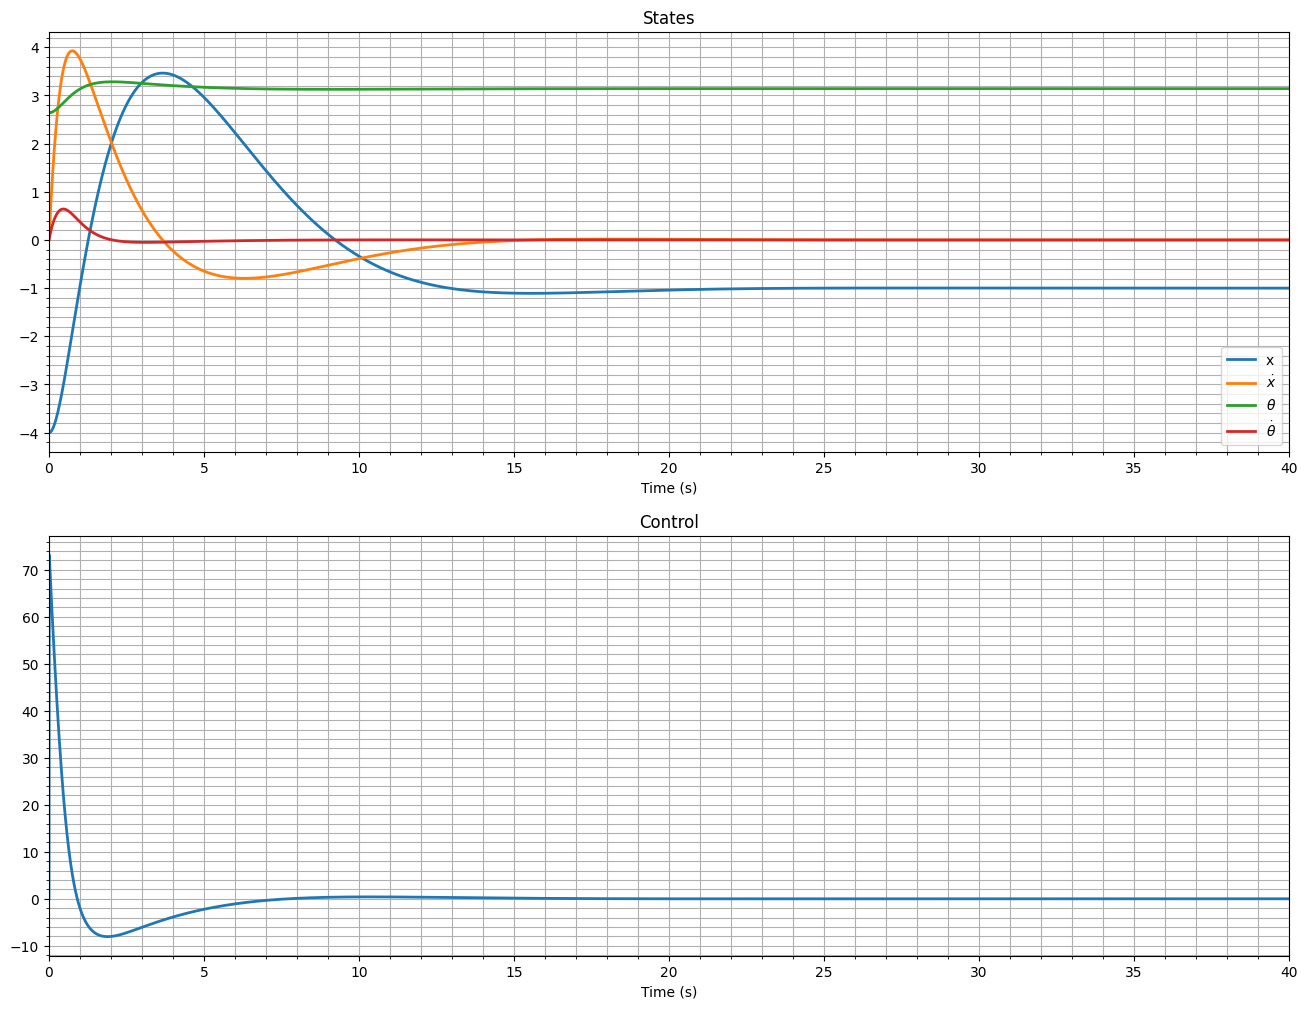

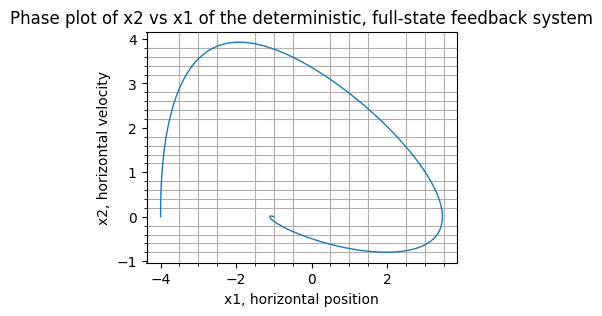

In [8]:
plt.figure(figsize=(16, 12))

plt.subplot(2, 1, 1)
lineWidth = 2
plt.plot(T[0], x[0, :], label = 'x', linewidth = lineWidth)
plt.plot(T[0], x[1, :], label = r'$\dot x$', linewidth = lineWidth)
plt.plot(T[0], x[2, :], label = r'$\theta$', linewidth = lineWidth)
plt.plot(T[0], x[3, :], label = r'$\dot \theta$',linewidth = lineWidth)
plt.xlabel("Time (s)")
plt.title("States")
plt.minorticks_on()
plt.grid(which = 'both')
plt.xlim(0, tf)
plt.legend(loc='best', fontsize=10)

plt.subplot(2, 1, 2)
plt.plot(T[0], u, linewidth=2)
plt.title("Control")
plt.xlabel("Time (s)")
plt.minorticks_on()
plt.grid(which = 'both')
plt.xlim(0, tf)  
plt.show()

plt.figure(figsize=(4, 3))
plt.plot(x[0, :], x[1, :], linewidth=1)
plt.grid(True)
plt.ylabel("x2, horizontal velocity")
plt.xlabel("x1, horizontal position")
plt.title("Phase plot of x2 vs x1 of the deterministic, full-state feedback system")
plt.minorticks_on()
plt.grid(which = 'both')
plt.show()

In [9]:
def draw_cart_pendulum(ax, y, m, M, L):
    x = y[0]
    th = y[2]

    # dimensions
    W = 1 * np.sqrt(M / 5)  # cart width
    H = 0.5 * np.sqrt(M / 5)  # cart height
    wr = 0.2  # wheel radius
    mr = 0.3 * np.sqrt(m)  # mass radius

    # positions
    cart_y = wr / 2 + H / 2  # cart vertical position
    w1x = x - 0.9 * W / 2
    w1y = 0
    w2x = x + 0.9 * W / 2 - wr
    w2y = 0
    px = x + L * np.sin(th)
    py = cart_y - L * np.cos(th)

    # clear the previous drawing
    ax.clear()

    ax.plot([-10, 10], [0, 0], 'w', linewidth=2)
    
    # Draw the cart
    ax.add_patch(patches.FancyBboxPatch((x - W / 2, cart_y - H / 2 + wr/2), W, H,
                                        boxstyle="round,pad=0.1", facecolor=[1, 0.1, 0.1], edgecolor=[1, 1, 1]))
    
    # Draw the wheels
    ax.add_patch(patches.Circle((w1x + wr / 2, w2y + wr / 2), wr / 2,
                                facecolor=[1, 1, 1], edgecolor=[1, 1, 1]))
    ax.add_patch(patches.Circle((w2x + wr / 2, w2y + wr / 2), wr / 2,
                                facecolor=[1, 1, 1], edgecolor=[1, 1, 1]))
    
    # Draw the pendulum line and the pendulum
    ax.plot([x, px], [cart_y, py], 'w', linewidth=2)
    ax.add_patch(patches.Circle((px, py), mr / 2,
                                facecolor=[0.3, 0.3, 1], edgecolor=[1, 1, 1]))

    ax.set_xlim([-5, 5])
    ax.set_ylim([-2, 2.5])
    ax.set_facecolor('k')
    ax.tick_params(axis='x', colors='w')
    ax.tick_params(axis='y', colors='w')
    fig.set_size_inches(8, 4)
    fig.patch.set_facecolor('k')
    fig.patch.set_alpha(1.0)

    display(fig)
    
    clear_output(wait = True)
    plt.pause(0.005)

    


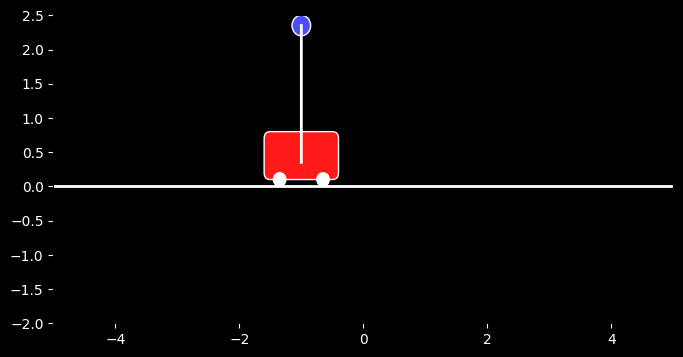

In [16]:
# Initialize the figure and axis
# fig, ax = plt.subplots()
# cart_patch = patches.FancyBboxPatch((0, 0), 1, 1, boxstyle="round,pad=0.1", facecolor=[1, 0.1, 0.1], edgecolor=[1, 1, 1])
# wheel1_patch = patches.Circle((0, 0), 0.1, facecolor=[1, 1, 1], edgecolor=[1, 1, 1])
# wheel2_patch = patches.Circle((0, 0), 0.1, facecolor=[1, 1, 1], edgecolor=[1, 1, 1])
# pendulum_line, = ax.plot([], [], 'w', linewidth=2)
# pendulum_patch = patches.Circle((0, 0), 0.1, facecolor=[0.3, 0.3, 1], edgecolor=[1, 1, 1])

# ax.add_patch(cart_patch)
# ax.add_patch(wheel1_patch)
# ax.add_patch(wheel2_patch)
# ax.add_patch(pendulum_patch)

# ax.set_xlim([-5, 5])
# ax.set_ylim([-2, 2.5])
# ax.set_facecolor('k')
# ax.tick_params(axis='x', colors='w')
# ax.tick_params(axis='y', colors='w')
# fig.set_size_inches(8, 4)
# fig.patch.set_facecolor('k')
# fig.patch.set_alpha(1.0)
# for k in range(0, max(T.shape)-1, 100):

fig, ax = plt.subplots()
for k in range(0, 4000, 5):
    # print (k)
    draw_cart_pendulum(ax,x[:, k], m, M, L)